**Few Shot Prompts, Upsampling, ROC Analysis, and LLM Model Evaluation and Comparison with Existing One (Presidio)**

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00


In [ ]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.3 MB/s eta 0:00:00


In [ ]:
import io
import os
import os; os.environ['OPENAI_API_KEY'] = 'insertkeyhere'

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain import PromptTemplate, LLMChain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

chat = ChatOpenAI(temperature=0)

In [ ]:
import pandas as pd
import datasets
from datasets import load_dataset
import pickle

In [ ]:
dataset = load_dataset("beki/privy", split="train")
with open("trainset.pkl", "wb") as File:
   pickle.dump(dataset, File)



In [ ]:
from google.colab import files
files.upload()

In [ ]:
train_data = pd.read_pickle("/content/train_upsampled.pkl")
train_sub = train_data.iloc[:2000]
train_sub.head()

__TODO__: Address class imbalance; aim for 60-80% negative examples and 20-40% positive examples.

Consider #1 or #2 of https://elitedatascience.com/imbalanced-classes, (might already be implemented in https://github.com/scikit-learn-contrib/imbalanced-learn which is documented in https://learn-scikit.oneoffcoder.com/imbalanced-learn.html)

In [ ]:
import multiprocessing
import concurrent.futures
from sklearn.utils import resample

In [ ]:
train_samples = train_sub["full_text"]

In [ ]:
label = list(map(lambda row: any(map(lambda x: 'US_ITIN' in x, row)), train_sub["spans"]))

In [ ]:
train_df = pd.DataFrame({
    'samples': train_samples,
    'label': label
})

In [ ]:
train_df[["label"]] *= 1
sum(train_df["label"] == 1)

54

In [ ]:
# Separate majority and minority classes
train_df_majority = train_df[train_df.label==0]
train_df_minority = train_df[train_df.label==1]

# Upsample minority class
train_df_minority_upsampled = resample(train_df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=1000,    # to match majority class
                                 random_state=200) # reproducible results

# Combine majority class with upsampled minority class
train_df_upsampled = pd.concat([train_df_majority, train_df_minority_upsampled])

# Display new class counts
train_df_upsampled.label.value_counts()

with open("train_upsampled.pkl", "wb") as File:
   pickle.dump(train_df_upsampled, File)


In [ ]:
ai_trainset = pd.read_pickle("train_upsampled.pkl")


__TODO__: Revise the system prompt message / few shot examples to improve the "evaluation metric"

Adjusting Few Shot Examples: Upsampled Training Set

In [ ]:
from langchain.prompts.chat import (
  HumanMessagePromptTemplate,
)
from tqdm.auto import tqdm

def make_chat_prompt(system_prompt, few_shot_examples):
  system_message_prompt = HumanMessagePromptTemplate.from_template(system_prompt)

  chat_template = [system_message_prompt]
  for eg_input, eg_response in few_shot_examples:
    example_human = HumanMessagePromptTemplate.from_template(eg_input)
    chat_template.append(example_human)

    example_ai = AIMessagePromptTemplate.from_template(eg_response)
    chat_template.append(example_ai)

  chat_template.append(
      HumanMessagePromptTemplate.from_template("Sample: {text}")
  )
  chat_prompt = ChatPromptTemplate.from_messages(chat_template)

  return chat_prompt


def get_probability_score(data, ai_prompt):
  probability_score = []
  for cprompt in tqdm(data):
    chain = LLMChain(llm=ChatOpenAI(temperature=0), prompt=ai_prompt)
    result = chain.run(cprompt)
    probability_score.append(str(result))
  return probability_score

chat_prompt = make_chat_prompt(
    system_prompt="""
Output a score between 0.001 and 0.99 indicating the likelihood the following string contains a SSN. Only output a float, no text.
""",
    few_shot_examples=[
      ("Sample: 'resourceGroupName': 'AnC', 'subscriptionId': 'gJ5sNIY'", "0.0"),
      ("Sample: 'taxid': '888776541'", "1.0"),
      ("Sample: 'prefix': 'Mr.'", "0.0"),
      ("Sample: 'chase': '445672753518468',", "0.0"),
      ("Sample: phone_number</th><td>396-821-9714</td></tr><tr><th>tax-identification-number</th><td>8546</td></tr><tr>", "0.8"),
      ("Sample: <table border='1'><tr><th>engine", "0.0"),
      ("Sample: 36-RG78,male,S,801-232-8314,3Wr", "1.0"),
  ]
)
probability_score = get_probability_score(ai_trainset["samples"], chat_prompt)
with open("ai_model_trainset.pkl", "wb") as File:
   pickle.dump(probability_score, File)



  0%|          | 0/2946 [00:00<?, ?it/s]

__NOTE__: this is slow because we are getting rate limited if concurrency is too high.

In [ ]:
# import multiprocessing


# def calc_stuff(prompt):
#   chain = LLMChain(llm=ChatOpenAI(temperature=0), prompt=chat_prompt)
#   result = chain.run(prompt)
#   return str(result)

# with multiprocessing.Pool(2) as p:
#   r = list(tqdm(p.imap(calc_stuff, bpdf["samples"]), total=bpdf.shape[0]))

In [ ]:
probability_score = pd.read_pickle("ai_model_trainset.pkl")

ai_trainset["probability_score"] = probability_score
#len(ai_trainset["samples"]) == len(probability_score)


#sum((ai_trainset["probability_score"] == '1.0') & (ai_trainset["label"] == 0))

In [ ]:
import numpy as np
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt


def roc_plot(y_scores, y_true):
  sklearn.metrics.roc_curve(y_true, y_scores, pos_label=True, sample_weight=None, drop_intermediate=True)
  y = y_true
  pred = y_scores
  fpr, tpr, thresholds = metrics.roc_curve(y, pred)
  roc_auc = metrics.auc(fpr, tpr)
  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
  display.plot()
  return plt.show()





In [ ]:
y_scores_train = pd.to_numeric(ai_trainset["probability_score"])
y_true_train = pd.to_numeric(ai_trainset["label"])
roc_plot(y_scores_train, y_true_train)

Adjusted Prompt and Few Shot: Upsampled Training Data Set

In [ ]:
from langchain.prompts.chat import (
  HumanMessagePromptTemplate,
)
from tqdm.auto import tqdm

def make_chat_prompt(system_prompt, few_shot_examples):
  system_message_prompt = HumanMessagePromptTemplate.from_template(system_prompt)

  chat_template = [system_message_prompt]
  for eg_input, eg_response in few_shot_examples:
    example_human = HumanMessagePromptTemplate.from_template(eg_input)
    chat_template.append(example_human)

    example_ai = AIMessagePromptTemplate.from_template(eg_response)
    chat_template.append(example_ai)

  chat_template.append(
      HumanMessagePromptTemplate.from_template("Sample: {text}")
  )
  chat_prompt = ChatPromptTemplate.from_messages(chat_template)

  return chat_prompt

def get_probability_score(data, ai_prompt):
  probability_score = []
  for cprompt in tqdm(data):
    chain = LLMChain(llm=ChatOpenAI(temperature=0), prompt=ai_prompt)
    result = chain.run(cprompt)
    probability_score.append(str(result))
  return probability_score




In [ ]:
chat_prompt = make_chat_prompt(
    system_prompt="""
Output a score between 0.001 and 0.99 computing the probability the following string contains a SSN. Only output a float, no text.
""",
    few_shot_examples=[
      ("Sample: 'resourceGroupName': 'AnC', 'subscriptionId': 'gJ5sNIY'", "0.0"),
      ("Sample: 'taxid': '888776541'", "1.0"),
      ("Sample: 'prefix': 'Mr.'", "0.0"),
      ("Sample: 'chase': '445672753518468',", "0.0"),
      ("Sample: phone_number</th><td>396-821-9714</td></tr><tr><th>tax-identification-number</th><td>8546</td></tr><tr>", "0.8"),
      ("Sample: <table border='1'><tr><th>engine", "0.0"),
      ("Sample: 36-RG78,male,S,801-232-8314,3Wr", "1.0"),
  ]
)

probability_score = get_probability_score(ai_trainset["samples"], chat_prompt)
with open("ai_model_trainset_p_fs.pkl", "wb") as File:
   pickle.dump(probability_score, File)

In [ ]:
probability_score = pd.read_pickle("ai_model_trainset_p_fs.pkl")

ai_trainset["probability_score"] = probability_score

__TODO__: Once we are happy with the "final" version of the model (prompt and few shot examples), compute ROC on the  test set and report it here.




In [ ]:
ai_trainset["probability_score"] = probability_score
sum((ai_trainset["probability_score"] == '1.0') & (ai_trainset["label"] == 0))

41

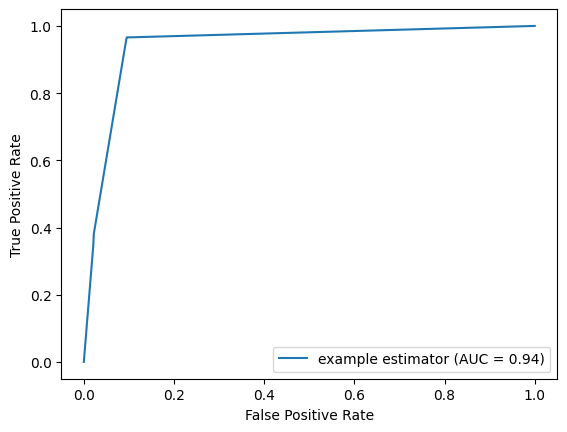

In [ ]:
# y_scores = pd.to_numeric(df_upsampled["probability_score"])
# y_true = pd.to_numeric(df_upsampled["label"])

# sklearn.metrics.roc_curve(y_true, y_scores, pos_label=True, sample_weight=None, drop_intermediate=True)
# y = y_true
# pred = y_scores
# fpr, tpr, thresholds = metrics.roc_curve(y, pred)
# roc_auc = metrics.auc(fpr, tpr)
# display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
# display.plot()

# plt.show()
y_scores_train = pd.to_numeric(ai_trainset["probability_score"])
y_true_train = pd.to_numeric(ai_trainset["label"])
roc_plot(y_scores_train, y_true_train)

In [ ]:
dataset = load_dataset("beki/privy", split="test")
with open("testset.pkl", "wb") as File:
   pickle.dump(dataset, File)


Generating train split:   0%|          | 0/100951 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/14422 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/28843 [00:00<?, ? examples/s]

In [ ]:
test_sub = dataset.to_pandas().iloc[:5000]

In [ ]:
test_samples = test_sub["full_text"]

In [ ]:
label = list(map(lambda row: any(map(lambda x: 'US_ITIN' in x, row)), test_sub["spans"]))

In [ ]:
testdf = pd.DataFrame({
    'samples': test_samples,
    'label': label
})

In [ ]:
testdf[["label"]] *= 1
sum(testdf["label"] == 1)

128

In [ ]:
# Separate majority and minority classes
testdf_majority = testdf[testdf.label==0]
testdf_minority = testdf[testdf.label==1]

# Upsample minority class
testdf_minority_upsampled = resample(testdf_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=2400,    # to match majority class
                                 random_state=1800) # reproducible results

# Combine majority class with upsampled minority class
testdf_upsampled = pd.concat([testdf_majority, testdf_minority_upsampled])

# Display new class counts
testdf_upsampled.label.value_counts()

with open("testdf_upsampled.pkl", "wb") as File:
   pickle.dump(testdf_upsampled, File)

In [ ]:
ai_testset = pd.read_pickle("testdf_upsampled.pkl")

Adjusted Prompt and Few Shot: Upsampled Testing Set

In [ ]:
chat_prompt = make_chat_prompt(
    system_prompt="""
Output a score between 0.001 and 0.99 computing the probability the following string contains a SSN. Only output a float, no text.
""",
    few_shot_examples=[
      ("Sample: 'resourceGroupName': 'AnC', 'subscriptionId': 'gJ5sNIY'", "0.0"),
      ("Sample: 'taxid': '888776541'", "1.0"),
      ("Sample: 'prefix': 'Mr.'", "0.0"),
      ("Sample: 'chase': '445672753518468',", "0.0"),
      ("Sample: phone_number</th><td>396-821-9714</td></tr><tr><th>tax-identification-number</th><td>8546</td></tr><tr>", "0.8"),
      ("Sample: <table border='1'><tr><th>engine", "0.0"),
      ("Sample: 36-RG78,male,S,801-232-8314,3Wr", "1.0"),
  ]
)

probability_score = get_probability_score(ai_testset["samples"], chat_prompt)
with open("ai_model_testset_p_fs.pkl", "wb") as File:
   pickle.dump(probability_score, File)

In [ ]:
probability_score = pd.read_pickle("ai_model_testset_p_fs.pkl")

ai_testset["probability_score"] = probability_score

In [ ]:
ai_testset["probability_score"] = probability_score
sum((ai_testset["probability_score"] == '1.0') & (ai_testset["label"] == 0))

109

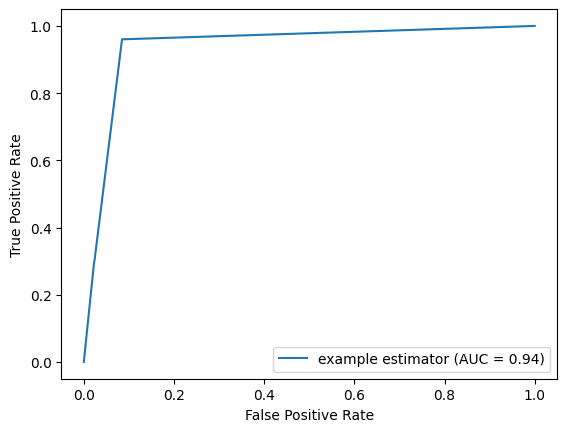

In [ ]:
y_scores_test = pd.to_numeric(ai_testset["probability_score"])
y_true_test = pd.to_numeric(ai_testset["label"])
roc_plot(y_scores_test, y_true_test)

Comparing to [Presidio](https://microsoft.github.io/presidio/getting_started/) [`US_SSN`](https://microsoft.github.io/presidio/supported_entities/) analyzer.

In [ ]:
!pip install presidio-analyzer
!pip install presidio-anonymizer
!python -m spacy download en_core_web_lg

In [ ]:
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine

text="My social is 212-55-5555"

# Set up the engine, loads the NLP module (spaCy model by default)
# and other PII recognizers
analyzer = AnalyzerEngine()

# Call analyzer to get results
results = analyzer.analyze(text=text,
                           entities=["US_SSN"],
                           language='en')
print(results)

# # Analyzer results are passed to the AnonymizerEngine for anonymization

# anonymizer = AnonymizerEngine()

# anonymized_text = anonymizer.anonymize(text=text,analyzer_results=results)

# print(anonymized_text)

[type: US_SSN, start: 13, end: 24, score: 0.85]


In [ ]:
def predict_with_presidio(text):
    results = analyzer.analyze(text=text,
                           entities=["US_SSN"],
                           language='en')
    for result in results:
      if result.entity_type == 'US_SSN':
        return result.score
    return 0.0

In [ ]:
def get_probability_score(data):
  probability_score = []
  for cprompt in tqdm(data):
    result = predict_with_presidio(cprompt)
    probability_score.append(str(result))
  return probability_score

In [ ]:
probability_score = get_probability_score(ai_testset["samples"])
with open("presidio_model_testset.pkl", "wb") as File:
   pickle.dump(probability_score, File)

  0%|          | 0/7272 [00:00<?, ?it/s]

In [ ]:
probability_score = pd.read_pickle("presidio_model_testset.pkl")

ai_testset["probability_score_pres"] = probability_score

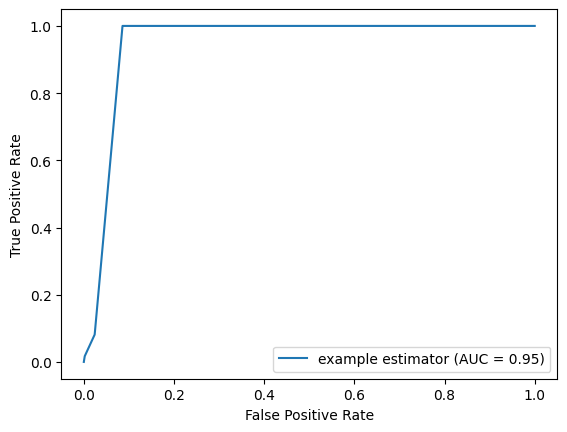

In [ ]:
y_scores_test = pd.to_numeric(ai_testset["probability_score_pres"])
y_true_test = pd.to_numeric(ai_testset["label"])
roc_plot(y_scores_test, y_true_test)